## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 66.1MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [ ]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 7.2 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=08be4bc0b9d4313352d478b83903d2ca6e33fad240380ce2db442e85c8d2537e
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [ ]:
import os
import time
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 
import collections
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jaccard
from sklearn.manifold import TSNE

import warnings
warnings.simplefilter('ignore')

In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
### パイプライン

# 数値データカラム名を取得
number_columns = df.select_dtypes(include="number").columns
number_columns = list(number_columns)

# カテゴリデータカラム名を取得
category_columns = df.select_dtypes(include="object").columns
category_columns = list(category_columns)

# 数値データ用の変換
numeric_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping = []

for column in df.select_dtypes(include="object"):
    ordinal_one_cols_mapping = []
    for category in natsorted(df[column].unique()):
        ordinal_one_cols_mapping.append(category)

    ordinal_all_cols_mapping.append(ordinal_one_cols_mapping)


# カテゴリー数が少ないカテゴリーデータ用の変換
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(
                handle_unknown = 'use_encoded_value', # 未知数をunknown valueに置き換える設定
                unknown_value = -1,
                categories = ordinal_all_cols_mapping
            )
        )
    ]
)

# ColumnTransformerの作成
columns_transformers = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, number_columns),
        ('category', categorical_transformer, category_columns),
    ]
)

# カラム変換用のパイプラインの作成
transformer = Pipeline(
    [
        ("columns_transformers", columns_transformers),
    ]
)

In [ ]:
df_tf = transformer.fit_transform(df)

all_columns = df.columns.tolist()
all_columns.remove("VGChartz_Score")

df_tf = pd.DataFrame(
    df_tf,
    columns = all_columns
)

print(len(df), len(df_tf))

55792 55792


### データセットの中から、2つのデータを抽出

In [ ]:
a_b = df_tf.sample(
            n = 2,
            random_state=SEED
        )

a = a_b.iloc[0:1]
b = a_b.iloc[1:]

display(a)
display(b)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
3335,-1.524951,-11.393998,0.013447,-0.053544,0.998917,0.914346,1.012772,-0.111138,0.432939,-0.80846,0.0,0.031255,28849.0,28636.0,15.0,6.0,48.0,78.0,453.0,403.0,9206.0,6940.0


,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
53545,1.592567,0.06627,13.637763,-0.053544,-0.169134,-0.14131,-0.136105,-0.111138,-0.13783,1.484128,0.0,0.031255,9290.0,9352.0,10.0,2.0,42.0,1194.0,3169.0,369.0,53637.0,31923.0


### コサイン類似度

In [ ]:
cosine_similarity(a, b)[0][0]

0.46408305161820873

### ジャッカード係数

In [ ]:
jaccard(a, b)

0.8571428571428571

### a と b の位置関係を、次元削減後の分布の中で見てみる

Text(51.00362777709961, 42.68579, 'b')

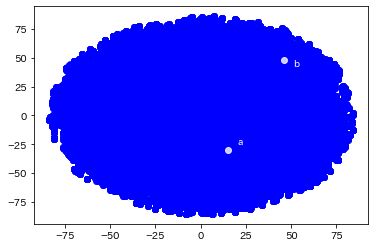

In [ ]:
sparse = 5

model = TSNE(
    n_components=2, 
    perplexity=5,
    random_state=SEED
    )

feature_all = model.fit_transform(df_tf)

plt.scatter(feature_all[:, 0], feature_all[:, 1], alpha=0.8, color="blue")

plt.scatter(feature_all[a.index[0], 0], feature_all[a.index[0], 1], alpha=0.8, color="white") # a
plt.text(feature_all[a.index[0], 0]+sparse, feature_all[a.index[0], 1]+sparse, "a", color="white")

plt.scatter(feature_all[b.index[0], 0], feature_all[b.index[0], 1], alpha=0.8, color="white") # b
plt.text(feature_all[b.index[0], 0] + sparse, feature_all[b.index[0] + sparse, 1], "b", color="white")

## 雑なレコメンド

In [ ]:
group = df_tf.sample(
            n = 51,
            random_state=SEED
        )

target = group.iloc[0:1]

group = group.iloc[1:]

print(len(target), len(group))

print("target")
display(df.iloc[target.index])

1 50
target


,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
3335,3336,South Park,south-park,Shooter,M,PS,Acclaim Entertainment,Appaloosa Interactive,NaN,1.7,NaN,NaN,0.71,0.39,0.27,NaN,0.05,1999.0,NaN,http://www.vgchartz.com/game/15272/south-park/...,1,NaN,/games/boxart/8319527ccc.jpg


### コサイン類似度の場合

In [ ]:
best_similarity_score = 0
num_of_best_best_similarity = ""

for i in tqdm(range(len(group))):

    one_of_group = group.iloc[i:i+1]

    score = cosine_similarity(target, one_of_group)[0][0]

    if best_similarity_score < score:
        best_similarity_score = score
        num_of_best_best_similarity = i

print(best_similarity_score)

print("target")
display(df.iloc[target.index])

print("サンプルで抽出した項目のうち、もっとも類似度が高いデータ")
display(df.iloc[group.iloc[num_of_best_best_similarity:num_of_best_best_similarity+1].index])

  0%|          | 0/50 [00:00<?, ?it/s]

0.9994433230982763
target


,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
3335,3336,South Park,south-park,Shooter,M,PS,Acclaim Entertainment,Appaloosa Interactive,NaN,1.7,NaN,NaN,0.71,0.39,0.27,NaN,0.05,1999.0,NaN,http://www.vgchartz.com/game/15272/south-park/...,1,NaN,/games/boxart/8319527ccc.jpg


サンプルで抽出した項目のうち、もっとも類似度が高いデータ


,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
51982,51983,Xenophobe,xenophobe,Action,NaN,7800,Atari,Atari,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1989.0,NaN,http://www.vgchartz.com/game/19851/xenophobe/?...,1,NaN,/games/boxart/9324175ccc.jpg


### ジャッカード係数の場合

In [ ]:
best_similarity_score = 0
num_of_best_best_similarity = ""

for i in tqdm(range(len(group))):

    one_of_group = group.iloc[i:i+1]

    score = jaccard(target, one_of_group)

    if best_similarity_score < score:
        best_similarity_score = score
        num_of_best_best_similarity = i

print(best_similarity_score)

print("target")
display(df.iloc[target.index])

print("サンプルで抽出した項目のうち、もっとも類似度が高いデータ")
display(df.iloc[group.iloc[num_of_best_best_similarity:num_of_best_best_similarity+1].index])

  0%|          | 0/50 [00:00<?, ?it/s]

0.9047619047619048
target


,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
3335,3336,South Park,south-park,Shooter,M,PS,Acclaim Entertainment,Appaloosa Interactive,NaN,1.7,NaN,NaN,0.71,0.39,0.27,NaN,0.05,1999.0,NaN,http://www.vgchartz.com/game/15272/south-park/...,1,NaN,/games/boxart/8319527ccc.jpg


サンプルで抽出した項目のうち、もっとも類似度が高いデータ


,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
292,293,"Pokemon: Let's Go, Pikachu!","pikachu""",Role-Playing,E,NS,Nintendo,Game Freak,NaN,8.3,NaN,NaN,4.57,2.16,1.24,0.82,0.34,2018.0,14th Nov 18,http://www.vgchartz.com/game/222024/pokemon-le...,1,8.0,/games/boxart/full_7522699AmericaFrontccc.jpg
